In [1]:
import numpy as np
import scipy
import scipy.spatial
from scipy.spatial.distance import squareform,pdist,cdist
import matplotlib.pyplot as plt
from scipy.io import mmread

from sklearn.manifold import TSNE
from joblib import Parallel, delayed

from timeit import default_timer as timer

from PIL import Image


In [ ]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath('..'))


In [2]:
from FP import *

In [3]:
import sys
del sys.modules['FP']
from FP import *

# 1

In [4]:
n= 400

theta = np.random.rand(n,2)
x= np.array([np.cos(theta[:,0]), np.sin(theta[:,0]), np.cos(theta[:,1]), np.sin(theta[:,1])]).T

In [5]:
from scipy.spatial.distance import cdist
import itertools
import concurrent.futures

# The function returns the objective value given a feature partitioning solution (including two partitions), where
# the omega is altered in coordA and coordB according to the values within p12_list.
#
# Input:
#   x : ndarray of shape (N, D)
#       Data matrix where N is the number of samples and D is the number of features.
#
#   omega : ndarray of shape (2, D)
#       Current feature partition weight matrix. Each feature is softly assigned to 
#       two partitions (rows 0 and 1), where row 1 is defined as the complement of row 0.
#
#   coordA : int
#       Index of the first feature to update.
#
#   coordB : int
#       Index of the second feature to update.
#
#   p12_list : tuple of two floats
#       Tuple (p1, p2) representing new soft/hard assignment probabilities of coordA and coordB 
#       to the first partition (row 0 of omega). The second partition is implicitly defined 
#       as 1 - assignment to the first.
#
#   perplexity : float
#       Perplexity parameter for constructing the affinity matrix (e.g., for t-SNE-style kernels).
#
#   delta : float, optional
#       Optional regularization parameter passed to FP_get_val.
#
# Output:
#   val : float
#       Evaluation score returned by FP_get_val using the updated omega and the optimal affinity matrix defined based on it (via FP_get_W).

def get_val(x, omega,coordA,coordB, p12_list ,perplexity,delta=None):
    p1,p2 =p12_list
    new_omega = omega+0.
    new_omega[0,coordA]= p1+0.
    new_omega[0,coordB]= p2+0.
    new_omega[1,:]=1-new_omega[0,:]

    new_W = FP_get_W(x, new_omega,perplexity)
    if delta is not None:
        return  FP_get_val(x, new_W,new_omega,perplexity,delta=delta)
    return FP_get_val(x, new_W,new_omega,perplexity)

# Computes a 2D loss landscape by evaluating the objective over a grid of soft assignments 
# for two selected features (coordA and coordB). Each grid point corresponds to a pair of 
# values (p1, p2) from the provided probability list(s), representing assignment strengths 
# to the first partition in omega.
#
# Input:
#   x : ndarray of shape (N, D)
#       Data matrix where N is the number of samples and D is the number of features.
#
#   omega : ndarray of shape (2, D)
#       Current feature partition weight matrix. Each feature is softly assigned to 
#       two partitions (rows 0 and 1), where row 1 is defined as the complement of row 0.
#
#   coordA : int
#       Index of the first feature to evaluate over the probability grid.
#
#   coordB : int
#       Index of the second feature to evaluate over the probability grid.
#
#   ps : 1D array-like
#       List of probability values to assign to coordA. Also used for coordB if psB is not provided.
#
#   perplexity : float
#       Perplexity parameter for constructing the affinity matrix (e.g., for t-SNE-style kernels).
#
#   delta : float, optional
#       Optional regularization parameter passed to FP_get_val.
#
#   psB : 1D array-like, optional
#       List of probability values to assign to coordB. If None, ps is used for both features.
#
# Output:
#   loss : ndarray of shape (len(ps), len(psB))
#       Grid of loss values corresponding to each (p1, p2) combination for coordA and coordB.

def get_loss_landscape(x,omega, coordA,coordB, ps,perplexity,delta=None,psB=None):
    if psB is None:
        psB = ps+0.
    
    loss= np.zeros((len(ps),len(ps)))
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda ab: get_val(x, omega,coordA,coordB, ab ,perplexity,delta), list(itertools.product(ps, ps))))
    return np.array(results).reshape((len(ps),len(ps)))
    

In [6]:
perplexity=10

# Our algorithm convergence by steps

## Step 1: Solve the regularized problem for delta1=\delta_{init}

In [7]:
# Set the initial regularization coefficient based on the data and perplexity
delta1= get_delta_init(x,2, perplexity)

In [8]:
# Extract the loss landscape around the initial feature partition solution, while varying either the last two or the first two coordinates
omega1= np.ones((2,4))
omega1[0,:]= np.array([0.49,0.51,0.49,0.51])
omega1[1,:]= 1-omega1[0,:]

ps= np.linspace(0,1,20)
loss1_23= get_loss_landscape(x,omega1, 2,3, ps,perplexity,delta=delta1)
loss1_01= get_loss_landscape(x,omega1, 0,1, ps,perplexity,delta=delta1)

In [9]:
# Run our algorithm for 10 iterations (alternating between optimizing the feature partitions and their corresponding affinity matrices)

omegas2=[omega1+0.]
for i in range(10):
    W2= FP_get_W(x, omegas2[-1],perplexity)
    omegas2.append(FP_get_omega(x, W2, delta1))


In [10]:
# Retrieve the final feature partition obtained
omega2=omegas2[-1]+0.

In [12]:
print(omega2)

[[0.49999842 0.49999549 0.50000151 0.50000458]
 [0.50000158 0.50000451 0.49999849 0.49999542]]


## Step 2: Solve the regularized optimization problem with delta2 = delta1 / 2, initialized from the previous solution

In [13]:
# Update the regularization coefficient (delta) for the next step
delta2=delta1/2

In [14]:
# Extract the loss landscape around the initial feature partition solution, while varying either the last two or the first two coordinates

loss2_23= get_loss_landscape(x,omega2, 2,3, ps,perplexity,delta=delta2)
loss2_01= get_loss_landscape(x,omega2, 0,1, ps,perplexity,delta=delta2)

In [15]:
# Run our algorithm for 10 iterations (alternating between optimizing the feature partitions and their corresponding affinity matrices)

omegas3=[omega2+0.]

for i in range(10):
    W3= FP_get_W(x, omegas3[-1],perplexity)
    omegas3.append(FP_get_omega(x, W3, delta2))


In [16]:
# Retrieve the final feature partition obtained
omega3=omegas3[-1]+0.

In [19]:
print(omega3)

[[0.4997757  0.49935855 0.50022179 0.50064368]
 [0.5002243  0.50064145 0.49977821 0.49935632]]


## Step 3: Solve the regularized optimization problem with delta3 = delta2 / 2, initialized from the previous solution

In [18]:
# Update the regularization coefficient (delta) for the next step
delta3=delta2/2

In [20]:
# Extract the loss landscape around the initial feature partition solution, while varying either the last two or the first two coordinates

loss3_23= get_loss_landscape(x,omega3, 2,3, ps,perplexity,delta=delta3)
loss3_01= get_loss_landscape(x,omega3, 0,1, ps,perplexity,delta=delta3)

In [21]:
# Run our algorithm for 10 iterations (alternating between optimizing the feature partitions and their corresponding affinity matrices)

omegas4=[omega3+0.]

for i in range(10):
    W4= FP_get_W(x, omegas4[-1],perplexity)
    omegas4.append(FP_get_omega(x, W4, delta3))


In [22]:
# Retrieve the final feature partition obtained

omega4=omegas4[-1]+0.

In [25]:
print(omega4)

[[2.41555905e-052 2.68984970e-166 1.00000000e+000 1.00000000e+000]
 [1.00000000e+000 1.00000000e+000 5.34420441e-060 1.60074241e-177]]


## Step 4: Solve the regularized optimization problem with delta4 = delta3 / 2, initialized from the previous solution

In [24]:
# Update the regularization coefficient (delta) for the next step
delta4=0.

In [26]:
# Extract the loss landscape around the initial feature partition solution, while varying either the last two or the first two coordinates

loss4_23= get_loss_landscape(x,omega4, 2,3, ps,perplexity,delta=delta4)
loss4_01= get_loss_landscape(x,omega4, 0,1, ps,perplexity,delta=delta4)

In [27]:
# Run our algorithm for 10 iterations (alternating between optimizing the feature partitions and their corresponding affinity matrices)

omegas5=[omega4+0.]

for i in range(10):
    W5= FP_get_W(x, omegas5[-1],perplexity)
    omegas5.append(FP_get_omega(x, W5, delta4))


In [28]:
# Retrieve the final feature partition obtained

omega5=omegas5[-1]+0.

# Solve the feature partitioning optimization problem directly (without regularization)

In [29]:
# Extract the loss landscape around the initial feature partition solution, while varying either the last two or the first two coordinates

hard_loss1_23= get_loss_landscape(x,omega1, 2,3, ps,perplexity,delta=0.)
hard_loss1_01= get_loss_landscape(x,omega1, 0,1, ps,perplexity,delta=0.)

In [30]:
# Run our algorithm for 10 iterations (alternating between optimizing the feature partitions and their corresponding affinity matrices)

omegas2_hard=[omega1+0.]

for i in range(10):
    W2_hard= FP_get_W(x, omegas2_hard[-1],perplexity)
    omegas2_hard.append(FP_get_omega(x, W2_hard, 0.))


In [31]:
# Retrieve the final feature partition obtained
omega2_hard= omegas2_hard[-1]+0.

In [32]:
# Extract the loss landscape around the initial feature partition solution, while varying either the last two or the first two coordinates

hard_loss2_23= get_loss_landscape(x,omega2_hard, 2,3, ps,perplexity,delta=0.)
hard_loss2_01= get_loss_landscape(x,omega2_hard, 0,1, ps,perplexity,delta=0.)

In [33]:
# Run our algorithm for 10 iterations (alternating between optimizing the feature partitions and their corresponding affinity matrices)

omegas3_hard=[omega2_hard+0.]

for i in range(10):
    W3_hard= FP_get_W(x, omegas3_hard[-1],perplexity)
    omegas3_hard.append(FP_get_omega(x, W3_hard, 0.))


# Generate the loss landscapes throughout both algorithms

In [35]:
vmin= np.min([np.min(loss1_01), np.min(loss1_23),np.min(loss2_01), np.min(loss2_23),np.min(loss3_01), np.min(loss3_23),\
             np.min(hard_loss1_01), np.min(hard_loss1_23)])
vmax= np.max([np.max(loss1_01), np.max(loss1_23),np.max(loss2_01), np.max(loss2_23),np.max(loss3_01), np.max(loss3_23),\
             np.max(hard_loss1_01), np.max(hard_loss1_23)])

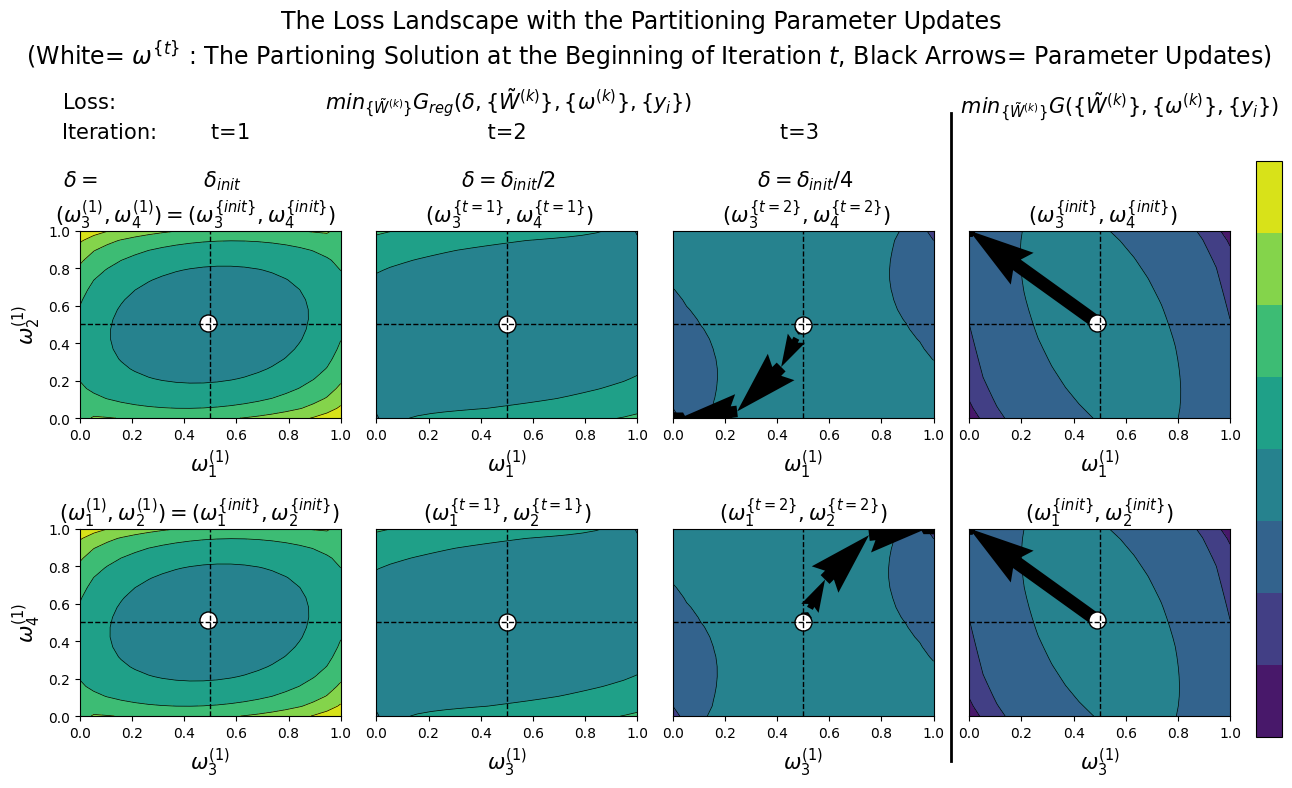

In [14]:
import matplotlib as mpl

f,ax= plt.subplots(2,4,figsize=(13,8))


levels = np.linspace(vmin, vmax, 9)
contourf_args = {"cmap": 'viridis', "levels":levels} # PuOr , inferno

X,Y = np.meshgrid(ps,ps)

im =ax[0,0].contourf(X, Y, loss1_01, **contourf_args)
ax[1,0].contourf(X, Y, loss1_23, **contourf_args)
ax[0,1].contourf(X, Y, loss2_01, **contourf_args)
ax[1,1].contourf(X, Y, loss2_23, **contourf_args)
ax[0,2].contourf(X, Y, loss3_01, **contourf_args)
ax[1,2].contourf(X, Y, loss3_23, **contourf_args)


ax[0,3].contourf(X, Y, hard_loss1_01, **contourf_args)
ax[1,3].contourf(X, Y, hard_loss1_23, **contourf_args)




ax[0,0].contour(X, Y, loss1_01, levels=levels, colors='black', linewidths=0.5)
ax[1,0].contour(X, Y, loss1_23, levels=levels, colors='black', linewidths=0.5)
ax[0,1].contour(X, Y, loss2_01, levels=levels, colors='black', linewidths=0.5)
ax[1,1].contour(X, Y, loss2_23, levels=levels, colors='black', linewidths=0.5)
ax[0,2].contour(X, Y, loss3_01, levels=levels, colors='black', linewidths=0.5)
ax[1,2].contour(X, Y, loss3_23, levels=levels, colors='black', linewidths=0.5)


ax[0,3].contour(X, Y, hard_loss1_01, levels=levels, colors='black', linewidths=0.5)
ax[1,3].contour(X, Y, hard_loss1_23, levels=levels, colors='black', linewidths=0.5)



for i in range(2):
    for j in range(ax.shape[1]):
        ax[i,j].axvline(x=0.5, color='black', linestyle='--', linewidth=1)  # vertical line
        ax[i,j].axhline(y=0.5, color='black', linestyle='--', linewidth=1)  # horizontal line



def myQuiver(ax,array1,array2):
    ax.quiver(array1[:-1],array2[:-1], np.diff(array1), np.diff(array2),angles='xy', scale_units='xy', \
              scale=1,width=0.05)
    
myQuiver(ax[0,0],np.array(omegas2)[:,0,0] ,np.array(omegas2)[:,0,1])
myQuiver(ax[1,0],np.array(omegas2)[:,0,2] ,np.array(omegas2)[:,0,3])
myQuiver(ax[0,1],np.array(omegas3)[:,0,0] ,np.array(omegas3)[:,0,1])
myQuiver(ax[1,1],np.array(omegas3)[:,0,2] ,np.array(omegas3)[:,0,3])
myQuiver(ax[0,2],np.array(omegas4)[:,0,0] ,np.array(omegas4)[:,0,1])
myQuiver(ax[1,2],np.array(omegas4)[:,0,2] ,np.array(omegas4)[:,0,3])

myQuiver(ax[0,3],np.array(omegas2_hard)[:,0,0] ,np.array(omegas2_hard)[:,0,1])
myQuiver(ax[1,3],np.array(omegas2_hard)[:,0,2] ,np.array(omegas2_hard)[:,0,3])

s=150
lw=1
ax[0,0].scatter(omega1[0,0],omega1[0,1],c='white',edgecolors='black',linewidth=lw,s=s)
ax[1,0].scatter(omega1[0,2],omega1[0,3],c='white',edgecolors='black',linewidth=lw,s=s)

ax[0,1].scatter(omega2[0,0],omega2[0,1],c='white',edgecolors='black',linewidth=lw,s=s)
ax[1,1].scatter(omega2[0,2],omega2[0,3],c='white',edgecolors='black',linewidth=lw,s=s)

ax[0,2].scatter(omega3[0,0],omega3[0,1],c='white',edgecolors='black',linewidth=lw,s=s)
ax[1,2].scatter(omega3[0,2],omega3[0,3],c='white',edgecolors='black',linewidth=lw,s=s)

ax[0,3].scatter(omega1[0,0],omega1[0,1],c='white',edgecolors='black',linewidth=lw,s=s)
ax[1,3].scatter(omega1[0,2],omega1[0,3],c='white',edgecolors='black',linewidth=lw,s=s)


ax[0,0].set_ylabel('$\omega^{(1)}_2$',fontsize=15)
ax[1,0].set_ylabel('$\omega^{(1)}_4$',fontsize=15)

for i in range(ax.shape[1]):
    ax[0,i].set_xlabel('$\omega^{(1)}_1$',fontsize=15)
    ax[1,i].set_xlabel('$\omega^{(1)}_3$',fontsize=15)

    if i>0:
        ax[0,i].set_yticks([])
        ax[1,i].set_yticks([])
        
plt.suptitle('The Loss Landscape with the Partitioning Parameter Updates \n '+\
             r'(White= $\omega^{\{t\}}$ : The Partioning Solution at the Beginning of Iteration $t$, Black Arrows= Parameter Updates)',fontsize=17)

ax[0,0].set_title('Iteration: $\qquad$ t=1 $\qquad\quad\qquad$ \n \n $ \delta= \qquad \qquad\quad   \delta_{init}  \qquad \qquad\qquad  $ \n $\; (\omega^{(1)}_3,\omega^{(1)}_4) =  (\omega^{\{init\}}_3,\omega^{\{init\}}_4)\qquad$ ',fontsize=15)
ax[0,1].set_title('Loss: $\qquad\qquad\qquad\qquad\qquad min_{\{ \\tilde{W}^{(k)}\}} G_{reg}( \delta, \{\\tilde{W}^{(k)}\}, \{\omega^{(k)}\},\{y_i\})  \qquad\qquad\qquad\qquad\qquad\qquad$   \n t=2 \n\n $\delta=\delta_{init}/2$ \n $(\omega^{\{t=1\}}_3,\omega^{\{t=1\}}_4)$',fontsize=15)
ax[0,2].set_title('t=3 \n \n $\delta= \delta_{init}/4$ \n $ (\omega^{\{t=2\}}_3,\omega^{\{t=2\}}_4)$',fontsize=15)

ax[0,3].set_title('$\qquad min_{\{\\tilde{W}^{(k)}\}} G( \{\\tilde{W}^{(k)}\}, \{\omega^{(k)}\},\{y_i\})$\n \n\n\n $ (\omega^{\{init\}}_3,\omega^{\{init\}}_4)$',fontsize=15)


ax[1,0].set_title('$(\omega^{(1)}_1,\omega^{(1)}_2) = (\omega^{\{init\}}_1,\omega^{\{init\}}_2)\quad$ ',fontsize=15)
ax[1,1].set_title('$(\omega^{\{t=1\}}_1,\omega^{\{t=1\}}_2)$',fontsize=15)
ax[1,2].set_title('$ (\omega^{\{t=2\}}_1,\omega^{\{t=2\}}_2)$',fontsize=15)

ax[1,3].set_title('$(\omega^{\{init\}}_1,\omega^{\{init\}}_2)$',fontsize=15)


line = plt.Line2D((.735,.735),(0.04,.85), color="k", linewidth=2)
f.add_artist(line)

plt.tight_layout()

f.subplots_adjust(right=0.95)
cbar_ax = f.add_axes([0.97, 0.07, 0.02, 0.72])
cbar= f.colorbar(im, cax=cbar_ax,ax=ax)
cbar.set_ticks([])


